### NEURON basics
In this notebook you will learn how to generate a compartment model using the 
NEURON simulator. 

If you haven't already, please make sure `NEURON` and `matplotlib` are installed:

```bash 
pip3 install neuron matplotlib -U
```

First up: importing the NEURON module

In [3]:
import neuron
from neuron import h  # <- this is where most functionality live

# We're using the most recent version of NEURON
neuron.__version__

'8.2.3'

NEURON compartment models consist of linear "sections" - i.e. bits of unbranched 
cable. 

In [4]:
# Define a single section
soma = h.Section(name="soma")

Sections have various passive properties (we'll get to the active properties 
later):

In [6]:
soma.psection()

{'point_processes': {},
 'density_mechs': {},
 'ions': {},
 'morphology': {'L': 100.0,
  'diam': [500.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x7f95e80f8000',
 'cell': None}

The `psection` method gives you a summary of the section's properties. Alternative,
we could also use `dir(soma)` to inspect available properties and methods. 

Annoyingly, the documentation for some of the available parameters is either
non-existing or at least well hidden. This is in large parts due to `NEURON`
written in hoc and just wrapped in Python. For functions and methods you can 
use `help()` and hope you get what you need. Otherwise, you need to try your
luck in the [official documentation](https://nrn.readthedocs.io/en/8.2.3/index.html).

For `Sections` the relevant parameters are:
- `L`: the length of the segment [`um`]
- `diam`: diameter of the segment [`um`]
- `Ra`: axial resistivity [`ohm*cm`]
- `cm`: specific membrane capacitance [`uF/cm^2`]


All the defaults (including `h.celcius` which is set to `6.3`) originate from 
the famous Hodkin and Huxely study of the squid giant axon. Bottom line: 
you will want to adjust these when modeling your non-cephalopod neurons.

In [21]:
# Reduce length and diameter to 20um
# (i.e. to mammalian neuron soma size)
soma.L = 20
soma.diam = 20

Other parameters can be adjusted in a similar way.

### Active properties

By default, a `Section` will only exhibit passive electrical properties. Any 
active _mechanisms_ have to be added explicitly. 

Here, "mechanism" refers to all kinds of active or passive channels/pumps. 
`NEURON` comes with a bunch of predefined mechanics but you can also download 
MOD files from [ModelDB](https://modeldb.science/) or write your own.

Let's insert channel kinetics from Hodgkin-Huxley:

In [22]:
# "hh" is short fo Hodgkin-Huxley
# To check, you could run soma.psection() again and inspect the various
# parameters
soma.insert("hh")

soma

OK, now we have a soma with a bunch of active and passive properties. Well, we
could check the current voltage difference in its center:

In [27]:
# the (0.5) is like inserting the electrode in the middle of the soma
soma(0.5).v

-65.0

## Running the simulation

So far so good. What if we increment the simulation by one step?

The size of the step is set via `h.dt` which defaults to `0.025ms`

In [39]:
h.dt

0.025

The current time is `0`

In [41]:
h.t

0.0

Advance by `dt` and inspect time

In [42]:
h.fadvance()
h.t

0.025

Has the voltage in our soma segment changed?

In [43]:
soma(0.5).v

-64.92034739454095

Well... a little! Looks like the initial -65mV isn't the resting potential for this 
cell.

We could just keep advancing the simulation via `h.fadvance()` and checking the 
voltage but that gets old quick (and it's slow).

Instead we will setup a variable that will record the potential for us and let 
the simulation run for a couple ms:

In [44]:
# Add a voltage recording for the soma
v = h.Vector().record(soma(0.5)._ref_v)

Note the use of `_ref_v`? This is another `NEURON` idiosyncrasie: you pass
`_ref_{variable}` as reference to tell the vector where and what to record.

We will also need to keep track of time:

In [45]:
# Note the use of `_ref_t` here
t = h.Vector().record(h._ref_t)

Now we can (almost) start running the simulation. Oddly, `NEURON` doesn't have 
a "run the simulation for X ms" function by default. For that we need to 
import a separate _hoc_ file:

In [46]:
h.load_file("stdrun.hoc")

1.0

OK, all set now. To run the simulation for 40ms:

In [47]:
# Use of units is good practice
from neuron.units import ms, mV

# Reset starting potential to -65mV
h.finitialize(-65 * mV)

# Run the simulation for 40ms
h.continuerun(40 * ms)

0.0

What now? Well, the simulation has run for 40ms and our results are in the 
recording variables `t` and `v` we set up earlier:

In [51]:
# Convert results to numpy arrays
v.as_numpy()

array([-65.        , -64.99925453, -64.99852075, ..., -64.974035  ,
       -64.97403521, -64.97403542])

Let's plot our results:

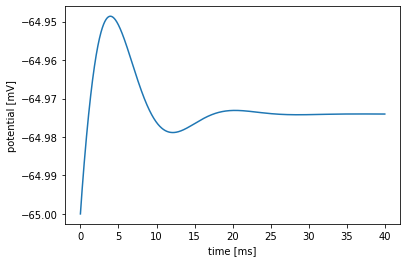

In [58]:
import matplotlib.pyplot as plt

# Plot voltage over time
_ = plt.plot(t.as_numpy(), v.as_numpy())

# Some cosmetics
ax = plt.gca()
ax.set_xlabel("time [ms]")
ax.set_ylabel("potential [mV]")

plt.show()

OK, so looks like the resting potential isn't actually substantially different 
from the initial -65mV...

## Stimulation!

Let's spice things up and inject some current in our cell! For that we need to
generate a stimulus and hook it up to `soma`:

In [60]:
iclamp = h.IClamp(soma(0.5))

`iclamp` is a current clamp stimulus which we attached to the center of our
`soma`. Like `Sections` it has a couple parameters we can tweak:

- `delay` [ms]: onset of the stimulus after simulation start 
- `dur` [ms]: duration after onset 
- `amp` [nA]: amplitude 

When in doubt you can use the `help` function to learn more about properties
(e.g. `help(h.IClamp)`).

In [61]:
iclamp.delay = 5
iclamp.dur = 0.1
iclamp.amp = 0.9

Now we can rerun the simulation

In [62]:
# Reset starting potential to -65mV
h.finitialize(-65 * mV)

# Run the simulation for 40ms
h.continuerun(40 * ms)

0.0

Do the plotting

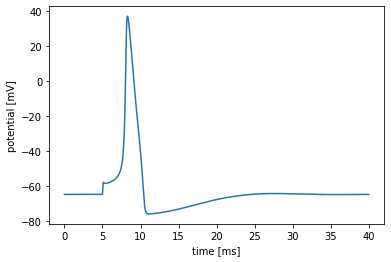

In [63]:
# Plot voltage over time
_ = plt.plot(t.as_numpy(), v.as_numpy())

# Some cosmetics
ax = plt.gca()
ax.set_xlabel("time [ms]")
ax.set_ylabel("potential [mV]")

plt.show()

Behold! Right on time (i.e. after `5ms`) our stimulus injected a current that
depolarized our soma above threshold and it fired a single action potential.

Now you have _15min_ to play around with the above. Please download this notebook
and run on your machine or collaboratory. A couple things you should try:

1. Generate a train of spikes in `soma`
2. Hyperpolarize `soma`
3. Stop a spike train by hyperpolarizing the cell